In [1]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Generate data
def generate_Corr_identity(p):

    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full,x_i

def fix_x_generate_data(n, p, sigma_sqr, beta, nu, corr,X):

    beta = beta.reshape((p, 1))
    XB = X @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y

# Calculate MSE
def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    if n == 0:
        return -1
    else:
        nu_origin_vec = nu_origin * np.ones((n, 1))
        mse = np.sum((nu_est - nu_origin_vec)**2) / n
        result = np.sqrt(mse)/nu_origin
        return result

# 1st step for profile
def negative_log_likelihood_optimize_beta_sigma(params, nu):
    """
    Negative log likelihood that will be passed into minimize function for given nu
    The use of it is to get the numerical result of beta and sigma
    :param params: contains beta and sigma as one vector, dim = p + 1
    :param nu: Degree of freedom
    :param X: Data matrix
    :param y: Observed Value
    :return: The negative log likelihood equation (2) in Fonseca 2008
    """

    betas, sigma = params[:-1], params[-1]
    sigma = np.abs(sigma) # Archer note: I simply let sigma to be its absolute value because it is symmetric.
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

# LS initial guess 
def initial_guess_from_lin_reg(x_without_1, y,nu_origin):
    initial_guess = []

    model = LinearRegression().fit(x_without_1, y)
    # intercept
    initial_guess.append(model.intercept_.item()) # Archer note: I modify the code to avoid py printing error.
    # coeff
    for coeff in model.coef_[0]:
        initial_guess.append(coeff)
    # sigma_sq
    y_pred = model.predict(x_without_1)
    residual_sq = (((y - y_pred)**2).sum())/(n-2)
    initial_guess.append(residual_sq)

    return initial_guess

# profile conditional MLE
def conditional_MLE(log_nu): 
    nu = np.exp(log_nu)

    p = X.shape[1]
    x_without_1 = X[:, 1:]
    initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='BFGS', options={'gtol': 1e-5, 'maxiter': 10000, 'norm':np.inf}) 
    
    return result.x

# 2nd step for profile
def negative_profile_loglikelihood(log_nu): 
    nu = np.exp(log_nu)
    p = X.shape[1]
    x_without_1 = X[:, 1:]
    initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='BFGS', options={'gtol': 1e-5, 'maxiter': 10000, 'norm':np.inf}) 

    if result.success == False:
        return(1e8) 
    else:
        return result.fun 
    
# Note that these are second derivatives of NEGATIVE log likelihood, we will fix it in the determinant code
def Hessian_beta_sigma(beta, sigma, nu, X, y):
    """
    The Hessian matrix of the negative log likelihood function
    :param beta: Coefficients
    :param sigma: Scale
    :param nu: Degree of freedom
    :param X: Data Matrix
    :param y: Observed Value
    :return: Hessian Matrix of beta and sigma on the log likelihood function, equation (2) Fonseca 2008
    """
    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        #total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2+ (-(residual**2) * 2* nu ) / ( (nu_sigma_sqr_plus_residual**2)) - 2*(residual**2)/(nu_sigma_sqr_plus_residual* (sigma**2))

    db2 = total_b2 * (nu+1)
    #dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    dbs = dsb
    ds2 = n/(sigma**2) + (nu+1)*total_s2

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hessian_beta_sigma(beta, sigma, nu, X, y))* -1 
    # need to multiply all entries by -1 as we were on negative scale
    
    return np.linalg.det(block)

# 2nd step for adj profile
def negative_adj_profile_loglikelihood(log_nu):
    nu = np.exp(log_nu)
    
    sigma = conditional_MLE(log_nu)[-1]
    beta = conditional_MLE(log_nu)[:-1]
    p = X.shape[1]
    B = np.reshape(beta, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    det = obs_block_det(beta, sigma, nu, X, y)

    negative_adj_profile_loglikelihood = negative_profile_loglikelihood(log_nu) + 0.5*np.log(abs(det))
    return negative_adj_profile_loglikelihood


# Jeff MAP
def negative_log_likelihood_all_params(params):
    betas, sigma, nu = params[:-2], params[-2], params[-1]
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def negative_full_joint(params):
    nu = params[-1]
    sigma = params[-2]
    return -logJeff(nu) - np.log(1/sigma) + negative_log_likelihood_all_params(params)

def initial_guess_plus_nu(x_without_1, y,nu_origin):
    initial_guess = []

    model = LinearRegression().fit(x_without_1, y)
    # intercept
    initial_guess.append(model.intercept_.item()) # Archer note: I modify the code to avoid py printing error.
    # coeff
    for coeff in model.coef_[0]:
        initial_guess.append(coeff)
    # sigma_sq
    y_pred = model.predict(x_without_1)
    residual_sq = (((y - y_pred)**2).sum())/(n-2)
    initial_guess.append(residual_sq)
    
    #nu
    initial_guess.append(nu_origin)

    return initial_guess

In [3]:
result_value_mse_profile = []
result_value_mse_adj_profile =[] 
result_value_mse_Jeff_profile = []
mle_profile_convergence =[]
mle_adj_profile_convergence=[]
map_Jeff_profile_convergence=[]
nu_list = []

n = 100
p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
sigma_sqr = 1.5
corr = generate_Corr_identity(p)

x_without_1 = np.random.normal(0, 1, (n, p - 1))
x_i_correlated = x_without_1 @ corr
ones = np.ones((n, 1))
X =  np.concatenate((ones, x_i_correlated), axis=1)

for nu_origin in range(1,26): # loop true nu 
    nu_list.append(nu_origin)
    initial_log_nu = np.log(nu_origin)
    
    mle_profile = []
    mle_adj_profile =[]
    map_profile =[]

    for j in range(50): # number of simulations 
        y = fix_x_generate_data(n, p, sigma_sqr, beta, nu_origin, corr, X) ## Generate data
        initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)
        initial_guess_with_nu = initial_guess_plus_nu(x_without_1, y,nu_origin)
        
        # profile likelihood MLE
        profile_optim = minimize(negative_profile_loglikelihood,initial_log_nu,method='Nelder-Mead', options={'maxiter': 10000})
        if profile_optim.success == True:
            mle_profile.append(np.exp(profile_optim.x))        
        
        # adj profile likelihood MLE
        adj_profile_optim = minimize(negative_adj_profile_loglikelihood,initial_log_nu,method='Nelder-Mead', options={'maxiter': 10000})
        if adj_profile_optim.success == True:
            mle_adj_profile.append(np.exp(adj_profile_optim.x))
            
        # profile Jeff MAP
        profile_Jeff_optim = minimize(negative_full_joint, initial_guess_with_nu, method='Nelder-Mead', bounds = [(None, None)] * p +[(0, np.inf)]*2, options={'maxiter': 10000} )
        if profile_Jeff_optim.success == True:
            map_profile.append(profile_Jeff_optim.x[-1])    
      
    # record averaged MSE 
    value_mse_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mse_profile.append(value_mse_profile)     
    value_mse_adj_profile = calculate_y_axix(nu_origin, mle_adj_profile)
    result_value_mse_adj_profile.append(value_mse_adj_profile) 
    value_mse_Jeff_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_mse_Jeff_profile.append(value_mse_Jeff_profile) 
    
    # record convergence rate
    mle_profile_convergence.append(len(mle_profile))
    mle_adj_profile_convergence.append(len(mle_adj_profile))
    map_Jeff_profile_convergence.append(len(map_profile))
    
    print(str(nu_origin) + ' true nu done')

df = pd.DataFrame({'nu': nu_list,
                   'MSE profile likellihood': result_value_mse_profile,
                    'MSE adj profile likellihood': result_value_mse_adj_profile,
                   'MSE Jeff profile joint': result_value_mse_Jeff_profile,
                   'profile likellihood covergence':mle_profile_convergence,
                   'adj profile likellihood covergence':mle_adj_profile_convergence,
                   'Jeff profile joint covergence':map_Jeff_profile_convergence,
                        })

1 true nu done
2 true nu done
3 true nu done
4 true nu done
5 true nu done
6 true nu done
7 true nu done
8 true nu done
9 true nu done
10 true nu done
11 true nu done
12 true nu done
13 true nu done
14 true nu done
15 true nu done
16 true nu done
17 true nu done
18 true nu done
19 true nu done
20 true nu done
21 true nu done
22 true nu done
23 true nu done
24 true nu done
25 true nu done


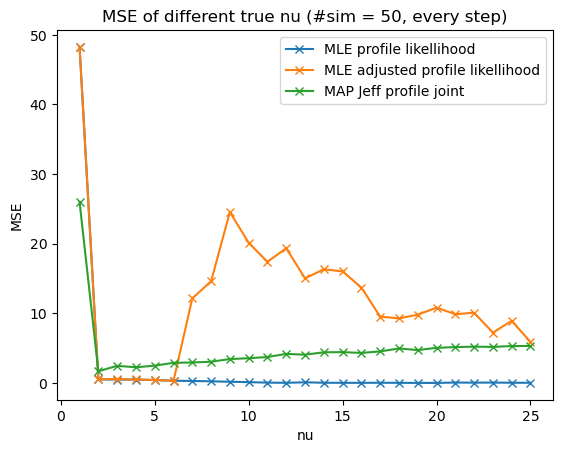

In [4]:
# Plot MSE vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile likellihood'], label='MLE profile likellihood', marker= "x")
plt.plot(df['nu'], df['MSE adj profile likellihood'], label='MLE adjusted profile likellihood', marker= "x")
plt.plot(df['nu'], df['MSE Jeff profile joint'], label='MAP Jeff profile joint', marker= "x")

# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('MSE')
plt.title('MSE of different true nu (#sim = 50, every step)') 
plt.legend()
# Showing the plot
plt.show()

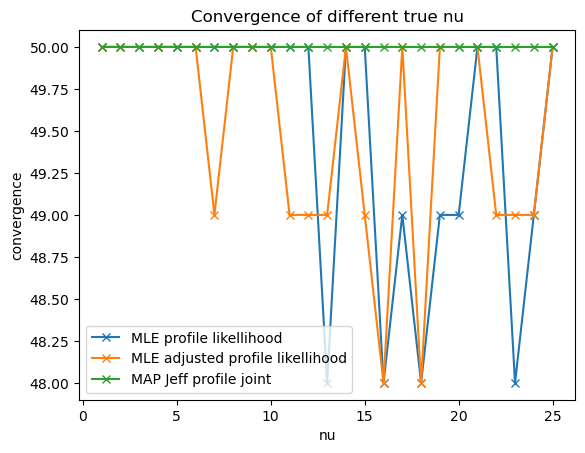

In [5]:
# Plot convergence vs nu 

# Plotting
plt.plot(df['nu'], df['profile likellihood covergence'], label='MLE profile likellihood', marker= "x")
plt.plot(df['nu'], df['adj profile likellihood covergence'], label='MLE adjusted profile likellihood', marker= "x")
plt.plot(df['nu'], df['Jeff profile joint covergence'], label='MAP Jeff profile joint', marker= "x")

# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('convergence')
plt.title('Convergence of different true nu') 
plt.legend()
# Showing the plot
plt.show()